This notebook was created by:
<p>-Basma El Khamlichi</p>
<p>-Mohamed Touzi</p>
<p>-Saad Handar</p>
<p>-Mohamed Dakkouri</p>
<p>-Josselin Masse</p>
<p>-Satnam Singh</p>



In [1]:
#import all the libraries
!pip install scikit-learn-extra
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import mean_squared_error

from datetime import datetime as dt 
from sklearn.model_selection import train_test_split
from pandas_datareader import data as pdr

     |████████████████████████████████| 1.7 MB 5.0 MB/s 


In [2]:
#importing csv file from google drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Neoma Business School/Applied Dataset SP500/Data/sp500_with_stock.csv' #Saad's path
#path = "/content/drive/My Drive/sp500_with_stock.csv" #Basma's path#

Mounted at /content/drive


In [3]:
sp500_Data=pd.read_csv(path,sep=";")

In [4]:
#Cleaning the CSV 
sp500_Data.columns[2:]
cols=[s.replace('WIKI/', '') for s in sp500_Data.columns[2:]] #erasinng Wiki/
cols=[s.replace(' - Adj. Close', '') for s in cols] # erasing - Adj. Close
cols.insert(0, 'Date') #renaming Date Column
cols.insert(1, 'SP500') #renaming the first column with sp500
sp500_Data.columns = cols 
sp500_Data['SP500']=pd.to_numeric(sp500_Data['SP500'],errors='coerce') #changing sp500 column to numeric

In [5]:
df_final=sp500_Data.iloc[:,1:].pct_change() #Calculate the return
df_final['Date']=sp500_Data['Date'] 
new_col=list(df_final.columns[:-1])
new_col.insert(0,'Date')
df_final=df_final[new_col]
df_final.fillna(0,inplace=True) #We fill nan values with 0
df_final.drop(0,inplace=True) #We drop them

In [6]:
fig = px.box(df_final, y="SP500",width=500, height=600,title='SP500 Box Plot')
fig.show()

In [7]:
#we separate the the data to train and test
train_ratio=0.8
train_size=round(len(df_final)*train_ratio)
test_size=len(df_final)-train_size
df_date_train=pd.to_datetime(df_final['Date'][:train_size], format='%d/%m/%Y', errors='ignore')
df_date_test=pd.to_datetime(df_final['Date'][train_size:], format='%d/%m/%Y', errors='ignore')

In [8]:
class NormalizeToUnit(tf.keras.constraints.Constraint):
    """
    constaint weights to unit normal
    """

    def __call__(self, w):
        
        #constraint weights to be positive: remove to allow begins short
        w=w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)
        #constrain weights to sum to 1
        w=w/tf.reduce_sum(w)
        return w

#regression loss
def regression_loss(X,Y,w):
    """
    compute square regression loss
    """
    Ypred=tf.squeeze(tf.matmul(X,w))
    loss = tf.keras.losses.MeanSquaredError()(Y,Ypred)
    return loss
#Down side risk
def downsiderisk(X,Y,w):
    """
    compute square regression loss
    """
    Ypred=tf.squeeze(tf.matmul(X,w))
    loss = tf.reduce_mean(tf.math.square(tf.keras.activations.relu(Y-Ypred)))
    return loss

In [9]:
#The function that calculate Y-predict
def calculate_Ypred(x_test,w):
  Ypred=tf.squeeze(tf.matmul(x_test,w))
  return Ypred

In [10]:
#The function that plot the prediction and sp500
def plot_pred(x_test,w):
  Y_pred=calculate_Ypred(x_test,w)
  plt.figure(figsize=(15, 10))
  plt.plot(df_date_test,Y_pred,label="predicted") # plotting by columns
  plt.plot(df_date_test,Y_test,label="SP500")
  plt.legend() 
  plt.show()

In [11]:
#The function that plot the 2 index to compare their performances
def plot_index_sp500(x_test,w):
  Y_pred=calculate_Ypred(x_test,w)
  prices_index=[]
  prices_sp500=[]
  initial=100
  value=initial
  for i in range(0,len(Y_test)):
    value=value+(value*Y_pred[i])
    prices_index.append(value)
  value=initial
  for i in range(0,len(Y_test)):
    value=value+(value*Y_test[i])
    prices_sp500.append(value)
  plt.figure(figsize=(15, 10))
  plt.plot(df_date_test,prices_index,label='index') # plotting by columns
  plt.plot(df_date_test,prices_sp500,label='sp500') 
  plt.legend()
  plt.show()

# Minimizing square loss


##50 random Stocks

In [12]:
#we select the 50 random stocks
nb_tracking_tickers=50
random_stocks=[]
for i in range(nb_tracking_tickers):
    random_stocks.append(random.choice(df_final.columns[2:]))

In [13]:
df_features=df_final[random_stocks]
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 0.9999999403953552


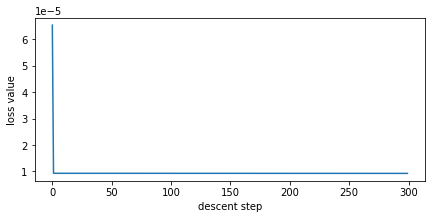

In [14]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=regression_loss(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [15]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 7.381058367172955e-06


In [16]:
weights = {'Stocks':random_stocks,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_random_stocks = pd.DataFrame(weights)
df_weights_random_stocks=df_weights_random_stocks.set_index('Stocks')
df_weights_random_stocks.transpose()

Stocks,NWSA,SYY,ADP,SLB,PKI,HLT,HSIC,SLB,INFO,ORLY,...,MRO,SRE,CINF,IT,SLB,TEL,NTAP,HCA,ZBH,BIO
Weights,0.024205,0.014856,0.022391,0.025083,0.025411,0.0,0.020003,0.025083,0.0,0.019949,...,0.038909,0.015897,0.020895,0.02142,0.025083,0.026141,0.023229,0.020581,0.021318,0.017323


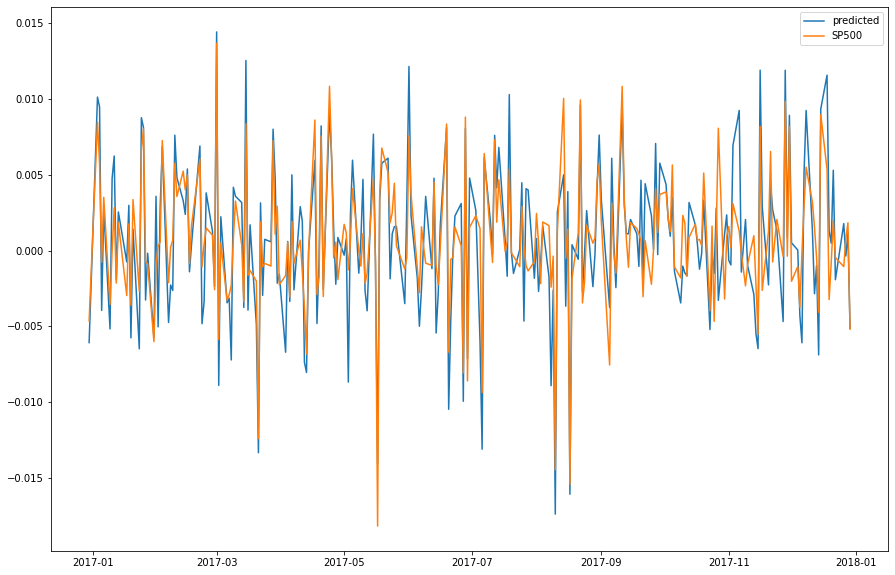

In [17]:
plot_pred(X_test,w)

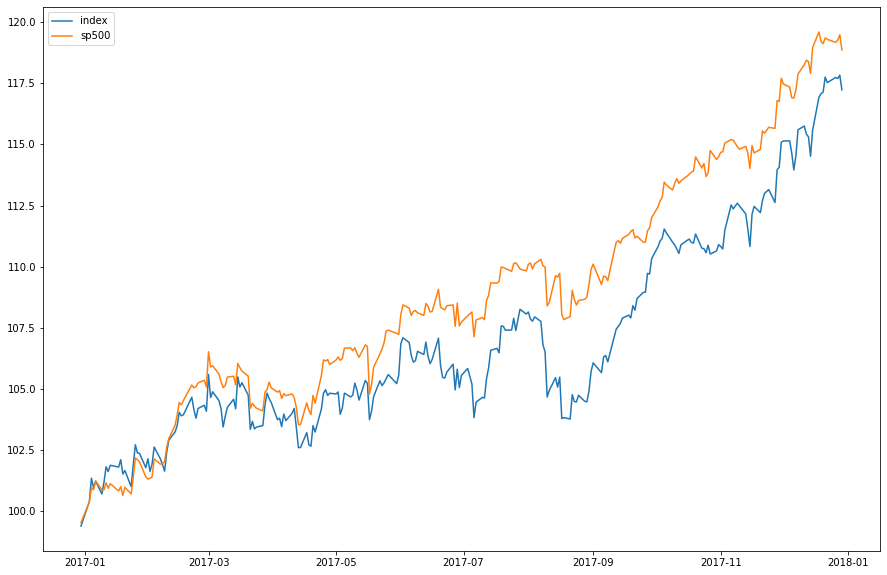

In [18]:
plot_index_sp500(X_test,w)

## 50 Most Corelated Stocks

In [19]:
sp500_cor=df_final.corr()['SP500'].sort_values(ascending=False)
top50_cor=sp500_cor[1:51]
df_50corr=df_final[top50_cor.index]

In [20]:
df_features=df_50corr
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


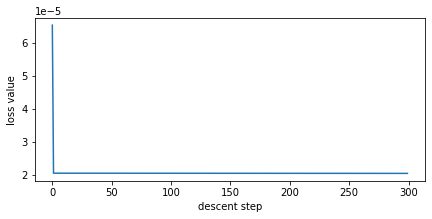

In [21]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=regression_loss(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [22]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 1.5194950719887856e-05


In [23]:
weights = {'Stocks':df_50corr.columns,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_50corr_stocks = pd.DataFrame(weights)
df_weights_50corr_stocks=df_weights_50corr_stocks.set_index('Stocks')
df_weights_50corr_stocks.transpose()

Stocks,BLK,HON,PFG,ITW,IVZ,AMP,MMC,JPM,USB,C,...,TDY,AFL,TEL,UNM,CINF,SCHW,MET,AIG,JKHY,TXN
Weights,0.024002,0.018039,0.024523,0.016956,0.026451,0.02527,0.015831,0.020946,0.016927,0.024471,...,0.018606,0.015658,0.019074,0.020912,0.015231,0.026093,0.023576,0.019678,0.014431,0.019441


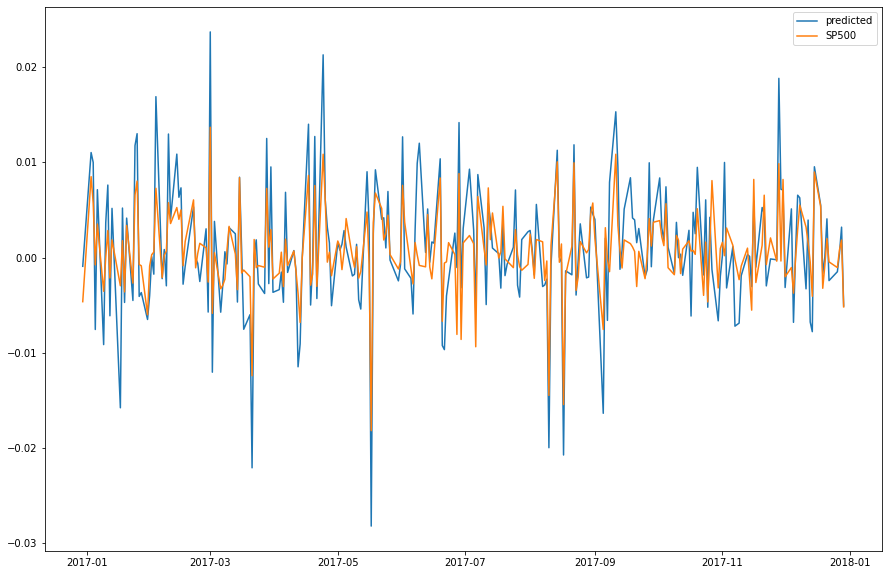

In [24]:
plot_pred(X_test,w)

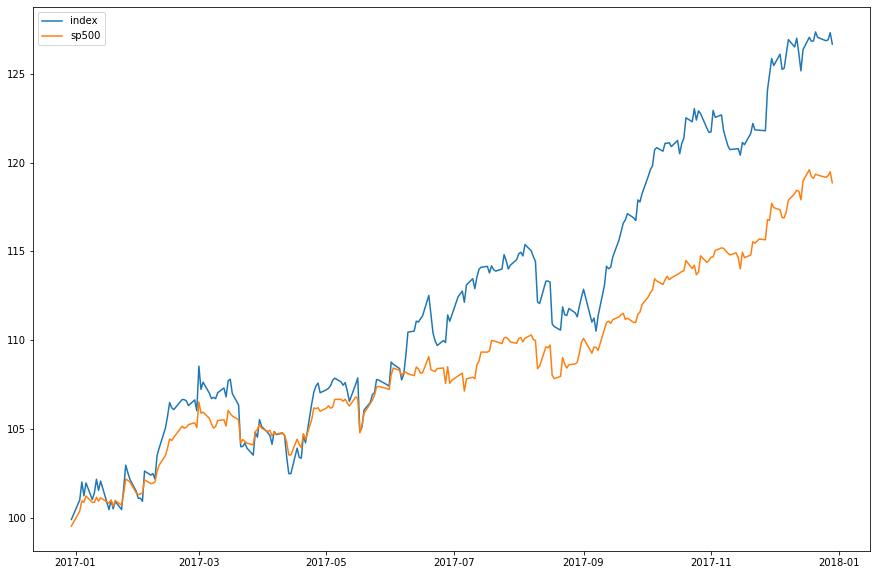

In [25]:
plot_index_sp500(X_test,w)

## 50 stocks using the Clustering

In [26]:
kmedoids = KMedoids(n_clusters=50, random_state=0).fit(df_final.iloc[:,2:].T)
stocks_index=kmedoids.medoid_indices_+2
df_clustering=df_final.iloc[:,stocks_index] 

/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning:

Cluster 30 is empty! self.labels_[self.medoid_indices_[30]] may not be labeled with its corresponding cluster (30).

/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning:

Cluster 34 is empty! self.labels_[self.medoid_indices_[34]] may not be labeled with its corresponding cluster (34).



In [27]:
df_features=df_clustering
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


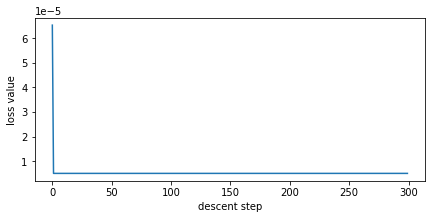

In [28]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=regression_loss(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [29]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 6.015949111315422e-06


In [30]:
weights = {'Stocks':df_clustering.columns,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_clust_stocks = pd.DataFrame(weights)
df_weights_clust_stocks=df_weights_clust_stocks.set_index('Stocks')
df_weights_clust_stocks.transpose()

Stocks,FISV,MMC,HON,ITW,MMM,L,AJG,PNC,JKHY,TMO,...,PPG,TRV,SYK,CL,NOC,WFC,DXC,BLK,BR,MCD
Weights,0.029554,0.027476,0.031305,0.029455,0.025935,0.026816,0.024112,0.032051,0.025015,0.033041,...,0.0,0.0,0.025264,0.022531,0.025982,0.031646,0.0,0.041761,0.026619,0.018872


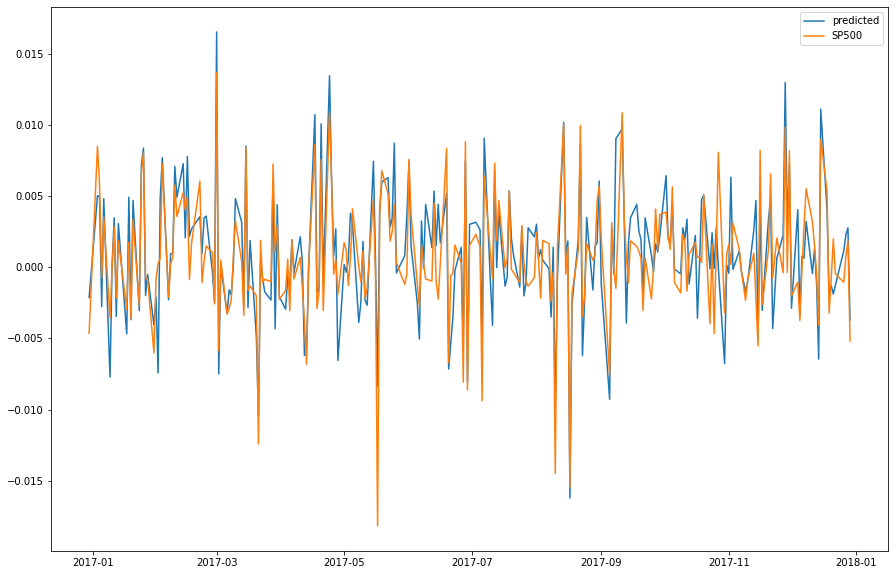

In [31]:
plot_pred(X_test,w)

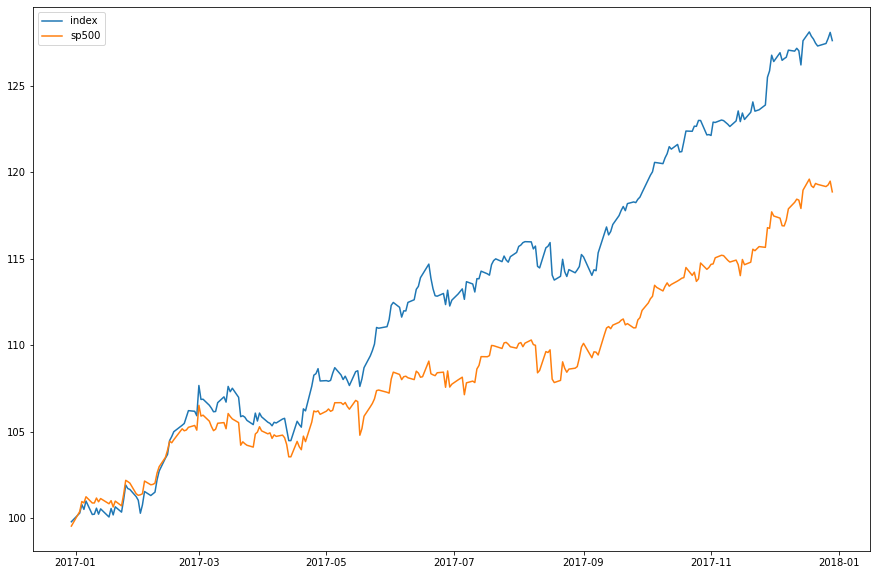

In [32]:
plot_index_sp500(X_test,w)

#Minimizing downside risk


### 50 random Stocks

In [33]:
df_features=df_final[random_stocks]
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0000001192092896


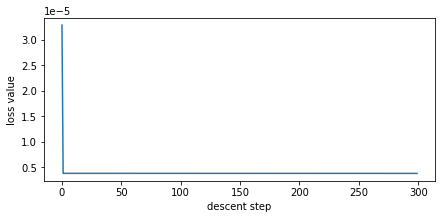

In [34]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=downsiderisk(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [35]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 7.12386827217415e-06


In [36]:
weights = {'Stocks':random_stocks,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_random_stocks = pd.DataFrame(weights)
df_weights_random_stocks=df_weights_random_stocks.set_index('Stocks')
df_weights_random_stocks.transpose()

Stocks,NWSA,SYY,ADP,SLB,PKI,HLT,HSIC,SLB,INFO,ORLY,...,MRO,SRE,CINF,IT,SLB,TEL,NTAP,HCA,ZBH,BIO
Weights,0.021155,0.015215,0.023122,0.024994,0.024535,0.0,0.020066,0.024994,0.0,0.021664,...,0.035656,0.016117,0.021514,0.02143,0.024994,0.025543,0.02194,0.019056,0.021138,0.017405


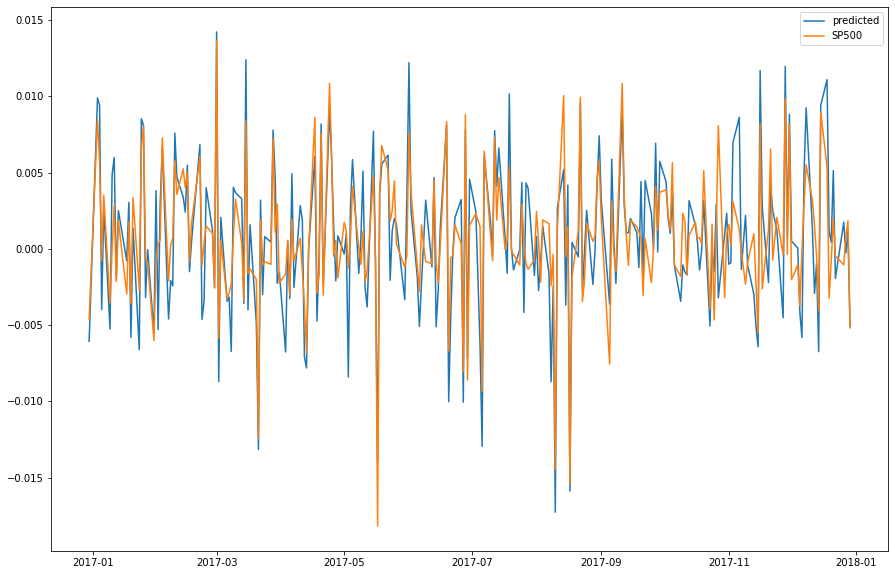

In [37]:
plot_pred(X_test,w)

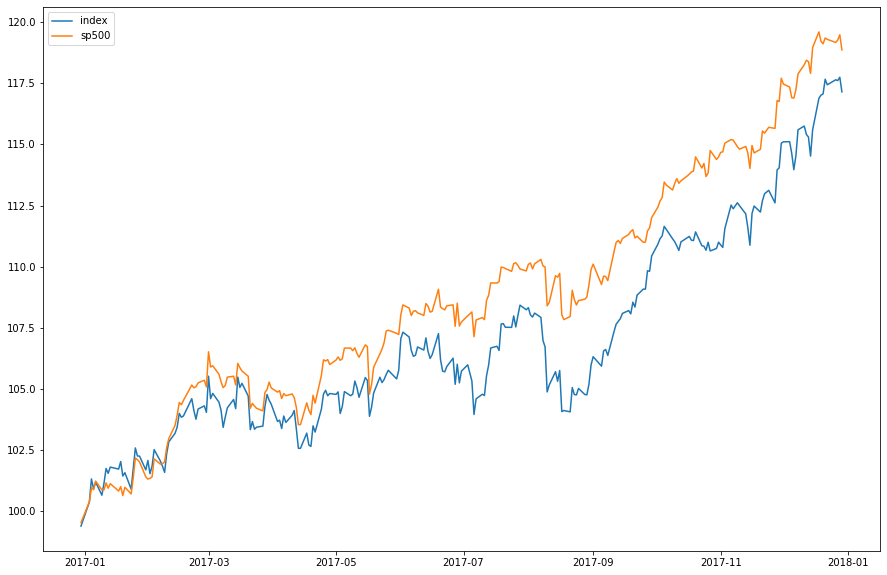

In [38]:
plot_index_sp500(X_test,w)

## 50 Most Corelated Stocks

In [39]:
df_features=df_50corr
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


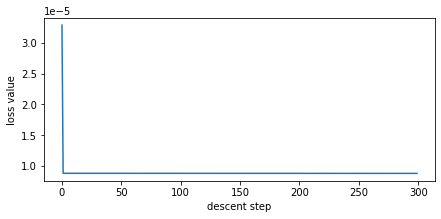

In [40]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=downsiderisk(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [41]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 1.4824063327978365e-05


In [42]:
weights = {'Stocks':df_50corr.columns,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_50corr_stocks = pd.DataFrame(weights)
df_weights_50corr_stocks=df_weights_50corr_stocks.set_index('Stocks')
df_weights_50corr_stocks.transpose()

Stocks,BLK,HON,PFG,ITW,IVZ,AMP,MMC,JPM,USB,C,...,TDY,AFL,TEL,UNM,CINF,SCHW,MET,AIG,JKHY,TXN
Weights,0.024009,0.019243,0.023494,0.017642,0.025424,0.025133,0.016428,0.021346,0.016502,0.02369,...,0.01832,0.016007,0.018906,0.020973,0.015933,0.025344,0.023893,0.019896,0.015118,0.020086


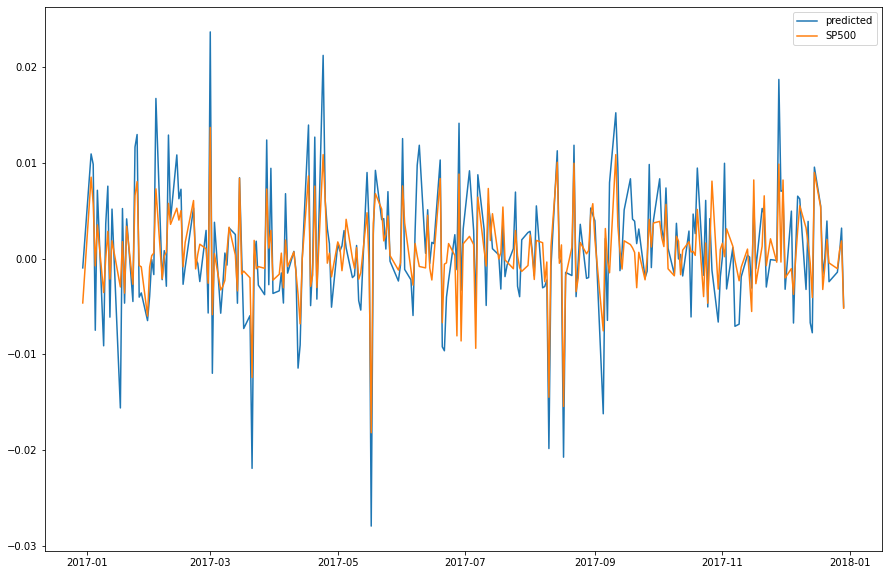

In [43]:
plot_pred(X_test,w)

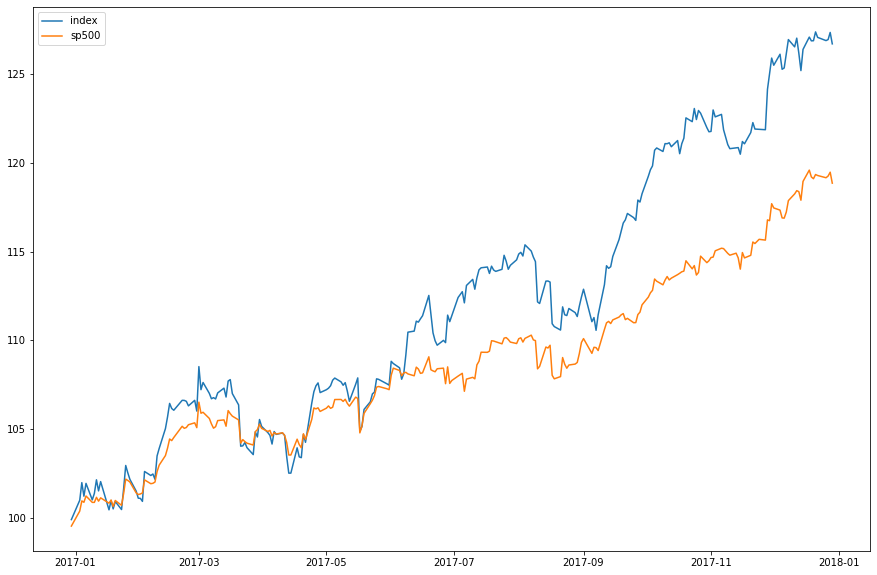

In [44]:
plot_index_sp500(X_test,w)

##50 stocks using the Clustering

In [45]:
df_features=df_clustering
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


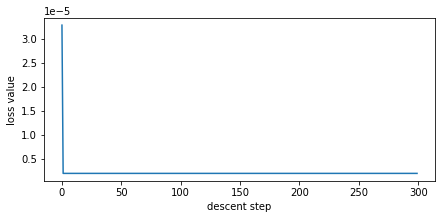

In [46]:
nb_descent_steps = 300

learning_rate = 0.01

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    with tf.GradientTape() as tape:
        loss=downsiderisk(X_train,Y_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()

In [47]:
test_loss=regression_loss(X_test,Y_test,w)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 6.0187217059137765e-06


In [48]:
weights = {'Stocks':df_clustering.columns,'Weights':np.reshape(w.numpy(), (-1, ))}
df_weights_clust_stocks = pd.DataFrame(weights)
df_weights_clust_stocks=df_weights_clust_stocks.set_index('Stocks')
df_weights_clust_stocks.transpose()

Stocks,FISV,MMC,HON,ITW,MMM,L,AJG,PNC,JKHY,TMO,...,PPG,TRV,SYK,CL,NOC,WFC,DXC,BLK,BR,MCD
Weights,0.030199,0.027505,0.032211,0.029551,0.026726,0.026189,0.022393,0.031289,0.025297,0.032839,...,0.0,0.0,0.025383,0.022159,0.02804,0.030261,0.0,0.04025,0.027696,0.019331


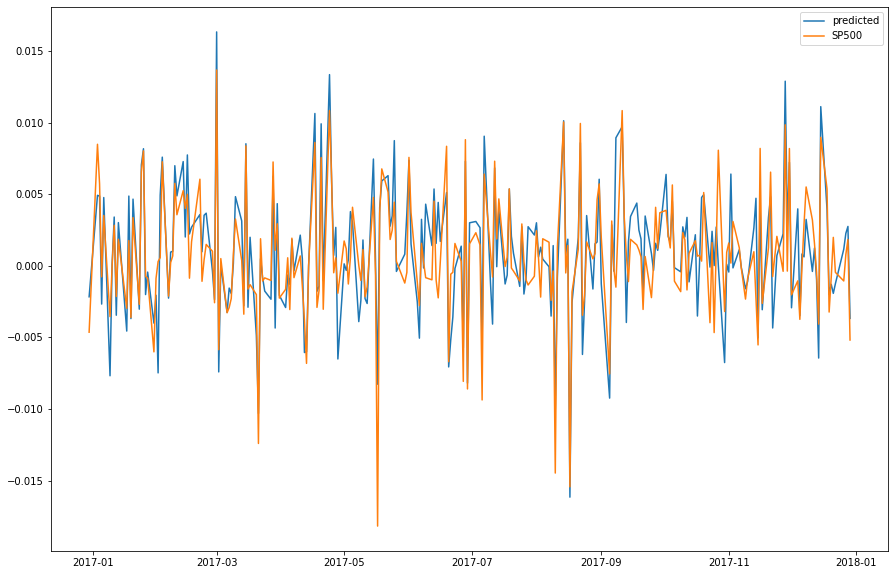

In [49]:
plot_pred(X_test,w)

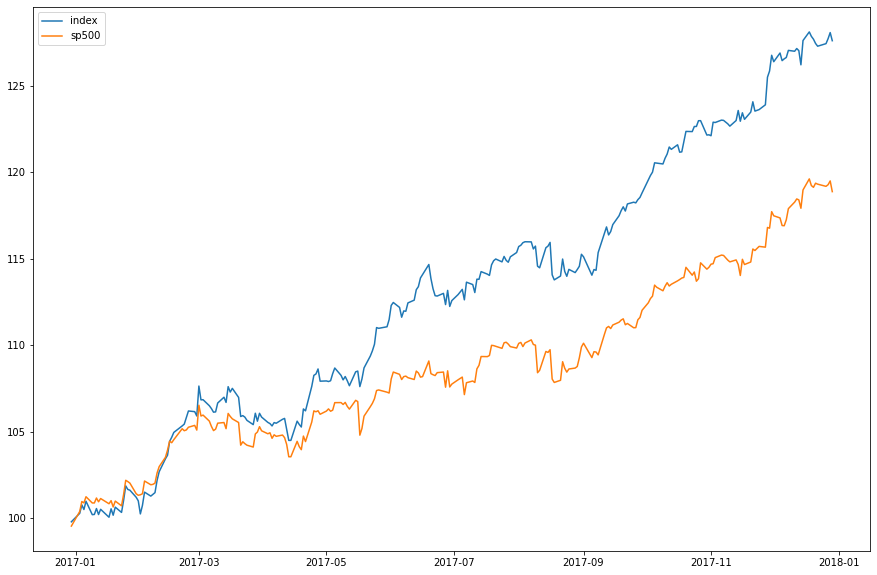

In [50]:
plot_index_sp500(X_test,w)

#Predicting sparse portfolio weights

##50 random stocks 

In [51]:
df_features=df_final[random_stocks]
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


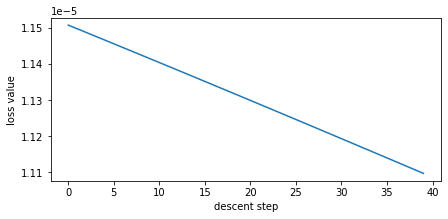

In [52]:
##############Draft##############Draft##############Draft
nb_descent_steps = 40

learning_rate = 0.01

time_period = 5

Weights_List =[]

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    #with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape:
      #
      for t in range(0, X_train.shape[0] - time_period, time_period):
        nextX_train = X_train[t:t + time_period,]
        nextY_train = Y_train[t:t + time_period,]

      
        loss=regression_loss(nextX_train,nextY_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

        Weights_List.append(w)

final_weights=np.array(Weights_List)[len(Weights_List)-int(len(X_train)/time_period):]
#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()
##############Draft##############Draft##############Draft

In [53]:
Y_predicted=final_weights[len(final_weights)-1].transpose().dot(X_test.numpy().transpose())

In [54]:
mean_squared_error(Y_test,Y_predicted.transpose())

1.1317722e-05

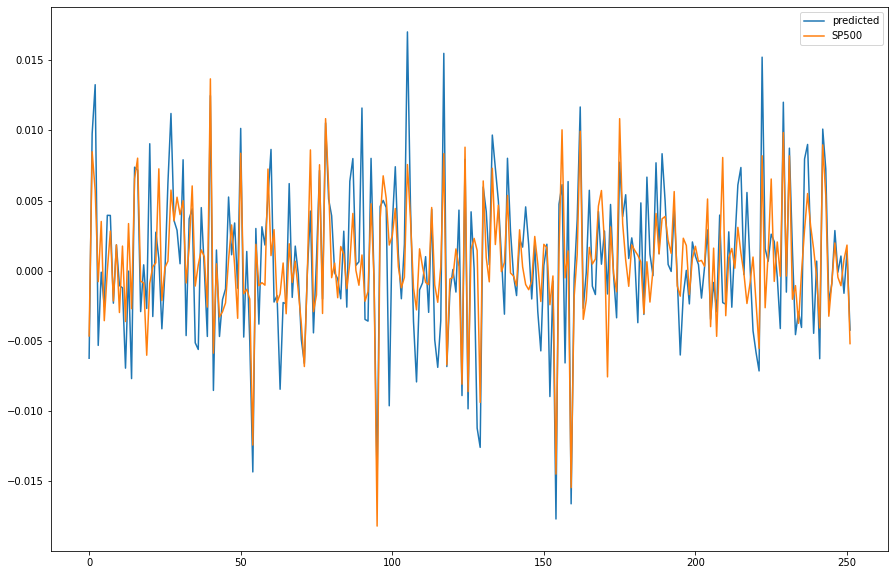

In [55]:
plt.figure(figsize=(15, 10))
plt.plot(Y_predicted.transpose(),label="predicted") # plotting by columns
plt.plot(Y_test,label="SP500")
plt.legend() 
plt.show()

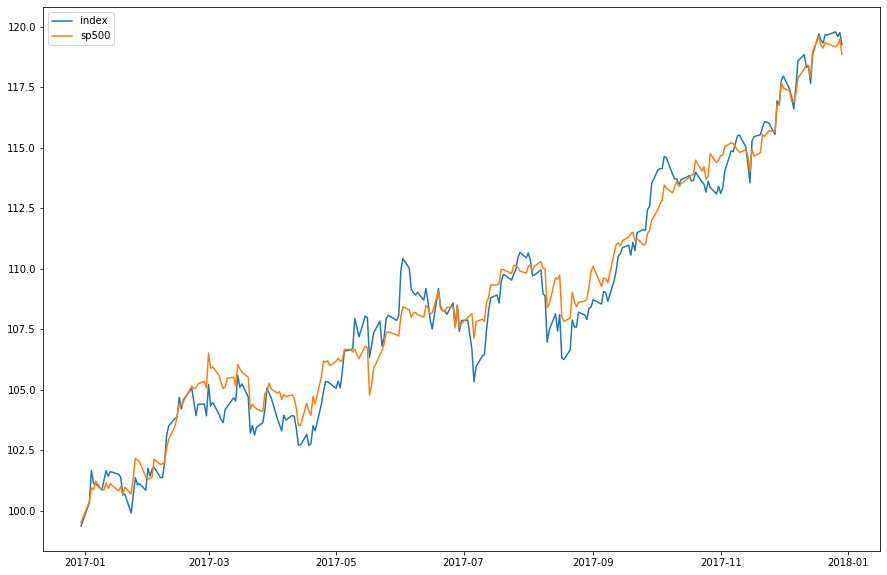

In [56]:
prices_index=[]
prices_sp500=[]
initial=100
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_predicted.transpose()[i])
  prices_index.append(value)
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_test[i])
  prices_sp500.append(value)
plt.figure(figsize=(15, 10))
plt.plot(df_date_test,prices_index,label='index') # plotting by columns
plt.plot(df_date_test,prices_sp500,label='sp500') 
plt.legend()
plt.show()

##50 Most corelated stocks 

In [57]:
df_features=df_50corr
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 1.0


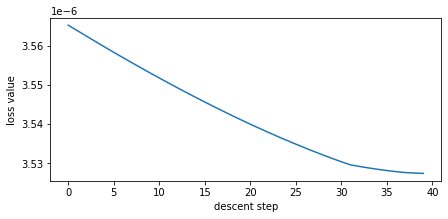

In [58]:
##############Draft##############Draft##############Draft
nb_descent_steps = 40

learning_rate = 0.01

time_period = 5

Weights_List =[]

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    #with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape:
      #
      for t in range(0, X_train.shape[0] - time_period, time_period):
        nextX_train = X_train[t:t + time_period,]
        nextY_train = Y_train[t:t + time_period,]

      
        loss=regression_loss(nextX_train,nextY_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

        Weights_List.append(w)

final_weights=np.array(Weights_List)[len(Weights_List)-int(len(X_train)/time_period):]
#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()
##############Draft##############Draft##############Draft

In [59]:
Y_predicted=final_weights[len(final_weights)-1].transpose().dot(X_test.numpy().transpose())

In [60]:
mean_squared_error(Y_test,Y_predicted.transpose())

1.7996324e-05

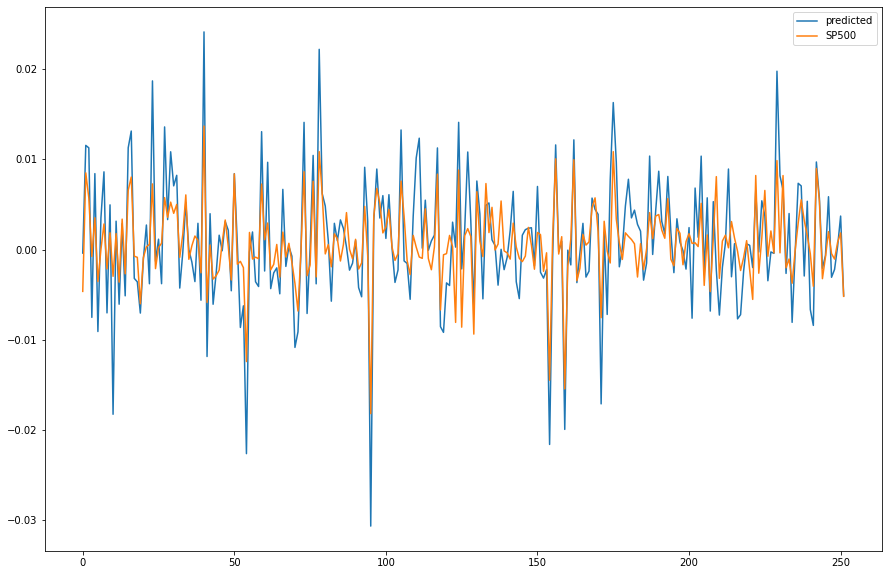

In [61]:
plt.figure(figsize=(15, 10))
plt.plot(Y_predicted.transpose(),label="predicted") # plotting by columns
plt.plot(Y_test,label="SP500")
plt.legend() 
plt.show()

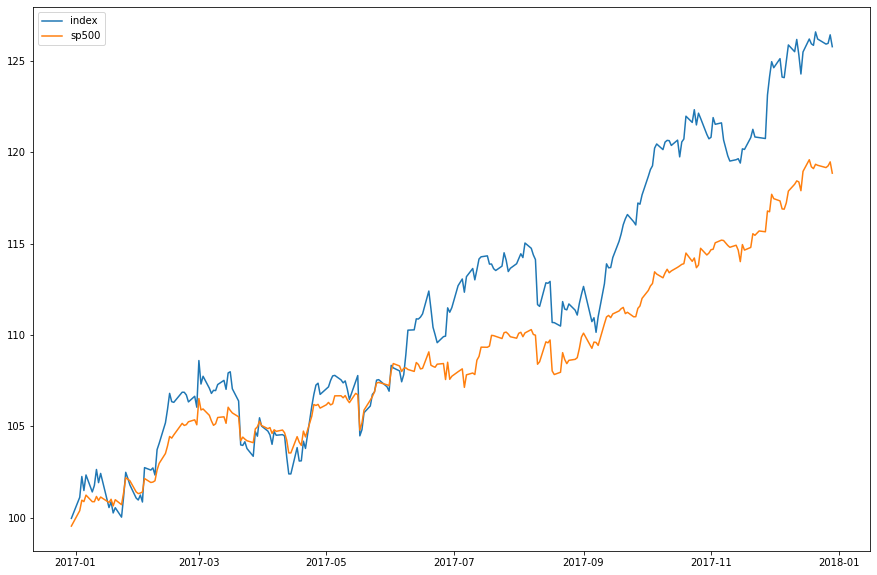

In [62]:
prices_index=[]
prices_sp500=[]
initial=100
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_predicted.transpose()[i])
  prices_index.append(value)
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_test[i])
  prices_sp500.append(value)
plt.figure(figsize=(15, 10))
plt.plot(df_date_test,prices_index,label='index') # plotting by columns
plt.plot(df_date_test,prices_sp500,label='sp500') 
plt.legend()
plt.show()

##50 Stocks Using Clustering 

In [63]:
df_features=df_clustering
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

 regression weights sum is 0.9999999403953552


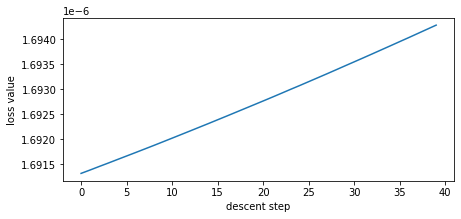

In [64]:
##############Draft##############Draft##############Draft
nb_descent_steps = 40

learning_rate = 0.01

time_period = 5

Weights_List =[]

optimizer=tf.keras.optimizers.SGD(learning_rate)

w=tf.Variable([[0.0]]*nb_tracking_tickers,dtype=tf.float32,trainable=True,constraint=NormalizeToUnit())

losses=[None]*nb_descent_steps

for n in range(nb_descent_steps):
    #with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape:
      #
      for t in range(0, X_train.shape[0] - time_period, time_period):
        nextX_train = X_train[t:t + time_period,]
        nextY_train = Y_train[t:t + time_period,]

      
        loss=regression_loss(nextX_train,nextY_train,w)
        losses[n]=loss.numpy()
        gradient=tape.gradient(loss,[w])
        optimizer.apply_gradients(zip(gradient,[w]))

        Weights_List.append(w)

final_weights=np.array(Weights_List)[len(Weights_List)-int(len(X_train)/time_period):]
#check that regression weights sums to 1
print(f" regression weights sum is {tf.reduce_sum(w)}")

#plot losses during gradient descent: if everything is ok loss have to decrease
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,3))
plt.plot(losses)
plt.xlabel('descent step')
plt.ylabel('loss value')
plt.show()
##############Draft##############Draft##############Draft

In [65]:
Y_predicted=final_weights[len(final_weights)-1].transpose().dot(X_test.numpy().transpose())

In [66]:
mean_squared_error(Y_test,Y_predicted.transpose())

6.332404e-06

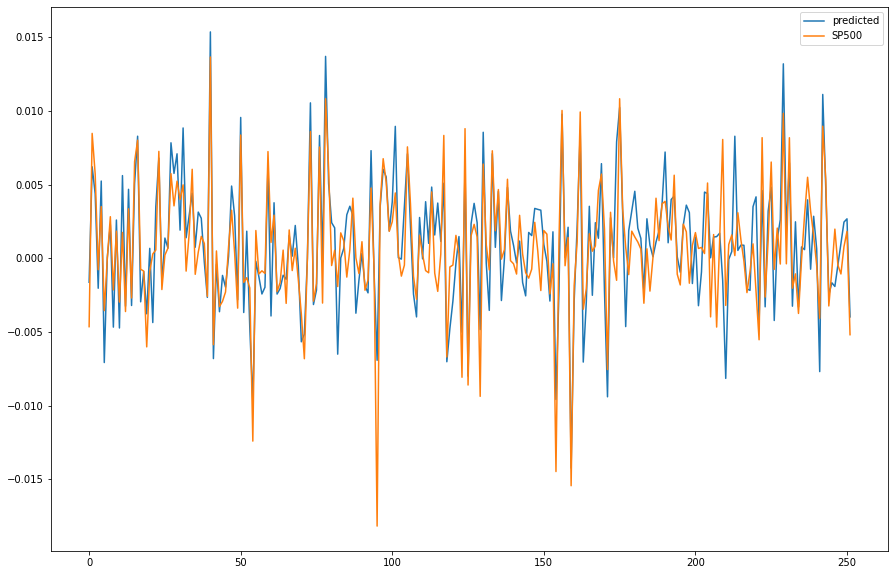

In [67]:
plt.figure(figsize=(15, 10))
plt.plot(Y_predicted.transpose(),label="predicted") # plotting by columns
plt.plot(Y_test,label="SP500")
plt.legend() 
plt.show()

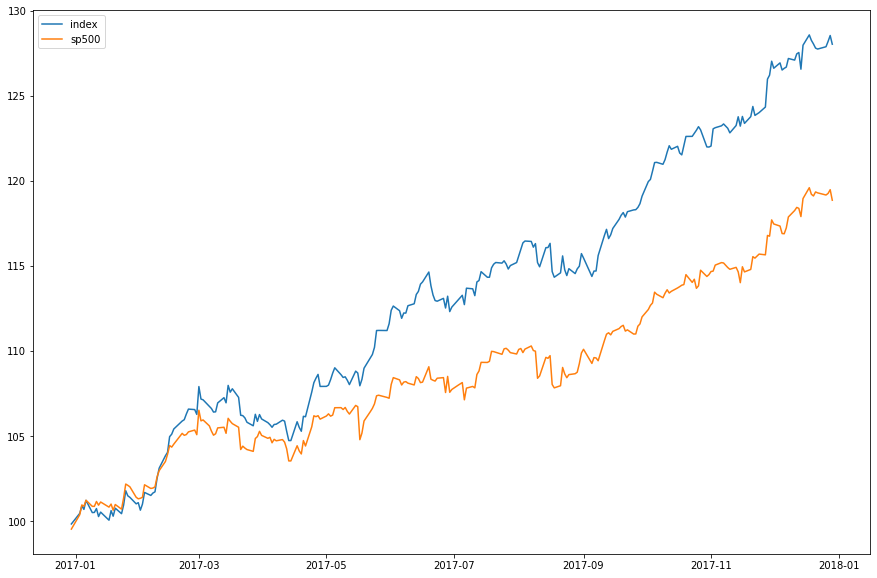

In [68]:
prices_index=[]
prices_sp500=[]
initial=100
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_predicted.transpose()[i])
  prices_index.append(value)
value=initial
for i in range(0,len(Y_test)):
  value=value+(value*Y_test[i])
  prices_sp500.append(value)
plt.figure(figsize=(15, 10))
plt.plot(df_date_test,prices_index,label='index') # plotting by columns
plt.plot(df_date_test,prices_sp500,label='sp500') 
plt.legend()
plt.show()

# Bonus Minimizing Square Loss Using SKlearn

## 50 Random Stocks

In [69]:
df_features=df_final[random_stocks]
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

In [70]:
#using Rige regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error
ridge = Ridge(alpha=0.4)
ridge.fit(X_train,Y_train)
Y_pred=ridge.predict(X_test)
print(f" The mean absolute error {mean_absolute_error(Y_test, Y_pred)}")
print(f" regression weights sum is {(ridge.coef_/(ridge.coef_.sum())).sum()}")
w_sk=ridge.coef_/(ridge.coef_.sum())
w_sklearn=tf.Variable(np.reshape(w_sk, (-1,1 )),dtype='float32')

 The mean absolute error 0.001629829586323326
 regression weights sum is 1.0


In [71]:
test_loss=regression_loss(X_test,Y_test,w_sklearn)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 5.670564860338345e-06


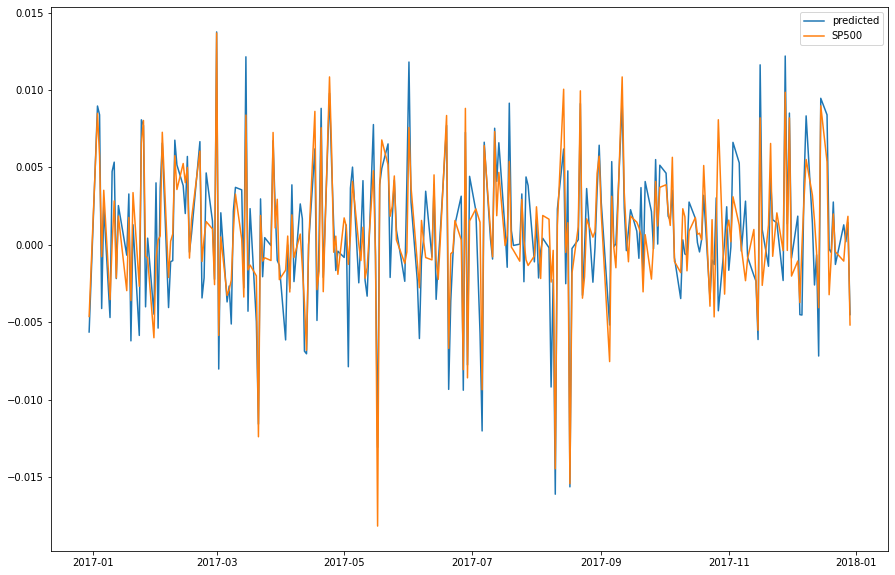

In [72]:
plot_pred(X_test,w_sklearn)

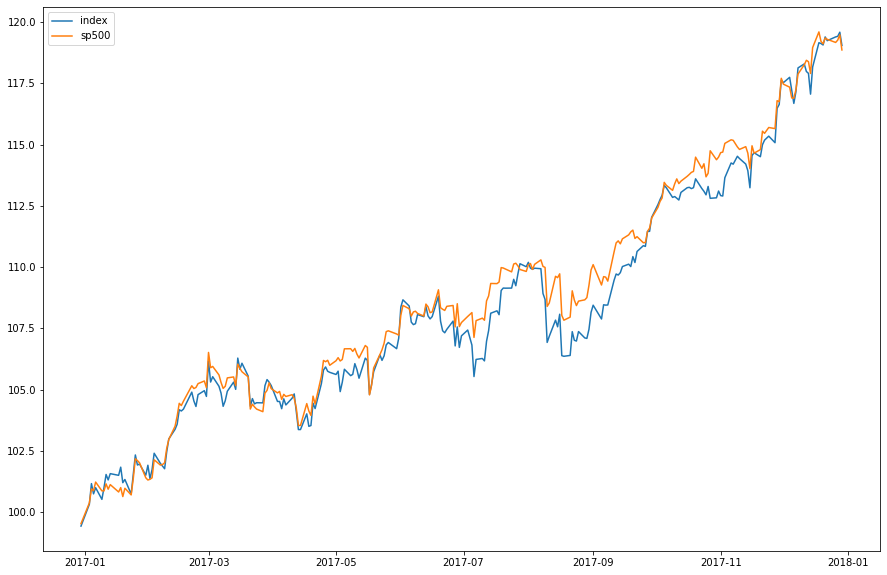

In [73]:
plot_index_sp500(X_test,w_sklearn)

## 50 Most correlated Stocks

In [74]:
df_features=df_50corr
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

In [75]:
#using Rige regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error
ridge = Ridge(alpha=0.4)
ridge.fit(X_train,Y_train)
Y_pred=ridge.predict(X_test)
print(f" The mean absolute error {mean_absolute_error(Y_test, Y_pred)}")
print(f" regression weights sum is {(ridge.coef_/(ridge.coef_.sum())).sum()}")
w_sk=ridge.coef_/(ridge.coef_.sum())
w_sklearn=tf.Variable(np.reshape(w_sk, (-1,1 )),dtype='float32')

 The mean absolute error 0.0015123751028428656
 regression weights sum is 1.0


In [76]:
test_loss=regression_loss(X_test,Y_test,w_sklearn)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 8.004121809790377e-06


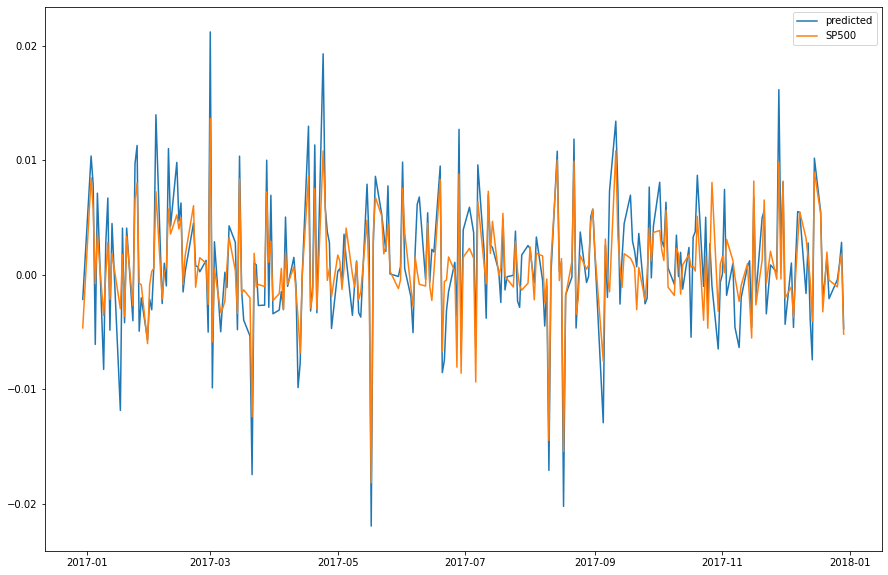

In [77]:
plot_pred(X_test,w_sklearn)

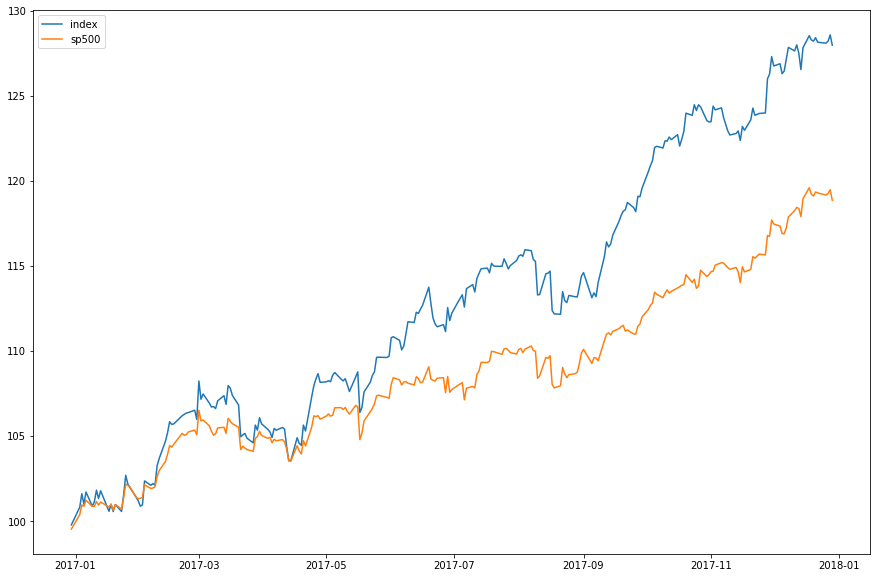

In [78]:
plot_index_sp500(X_test,w_sklearn)

## 50 stocks using clustering

In [79]:
df_features=df_clustering
df_target=df_final['SP500']
#Split to train and test datasets
X_train=tf.constant(df_features.iloc[:train_size,:].values,dtype=tf.float32)
X_test=tf.constant(df_features.iloc[train_size:,:].values,dtype=tf.float32)
Y_train=tf.constant(df_target.iloc[:train_size].values,dtype=tf.float32)
Y_test=tf.constant(df_target.iloc[train_size:].values,dtype=tf.float32)

In [80]:
#using Rige regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error
ridge = Ridge(alpha=0.4)
ridge.fit(X_train,Y_train)
Y_pred=ridge.predict(X_test)
print(f" The mean absolute error {mean_absolute_error(Y_test, Y_pred)}")
print(f" regression weights sum is {(ridge.coef_/(ridge.coef_.sum())).sum()}")
w_sk=ridge.coef_/(ridge.coef_.sum())
w_sklearn=tf.Variable(np.reshape(w_sk, (-1,1 )),dtype='float32')

 The mean absolute error 0.0016143952715534711
 regression weights sum is 1.0


In [81]:
test_loss=regression_loss(X_test,Y_test,w_sklearn)
print(f'Test loss is {test_loss.numpy()}')

Test loss is 5.58138390260865e-06


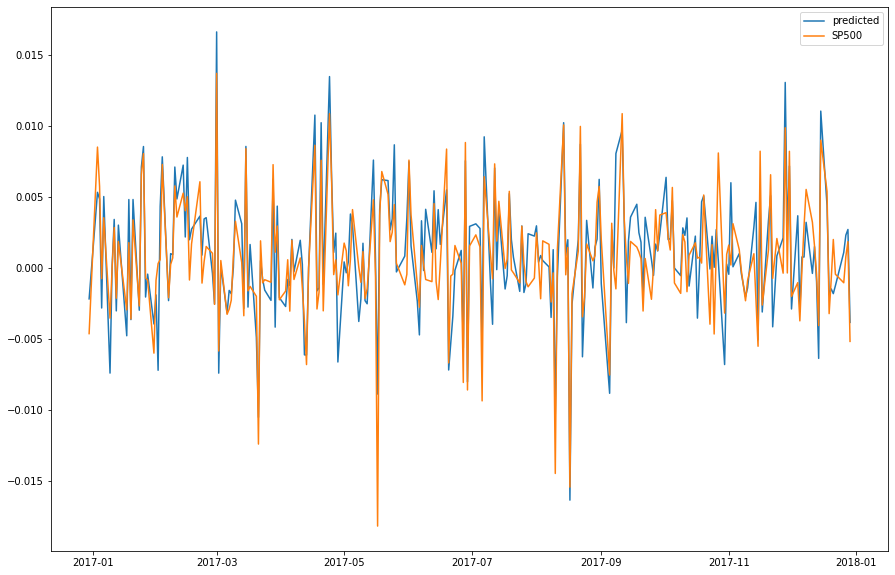

In [82]:
plot_pred(X_test,w_sklearn)

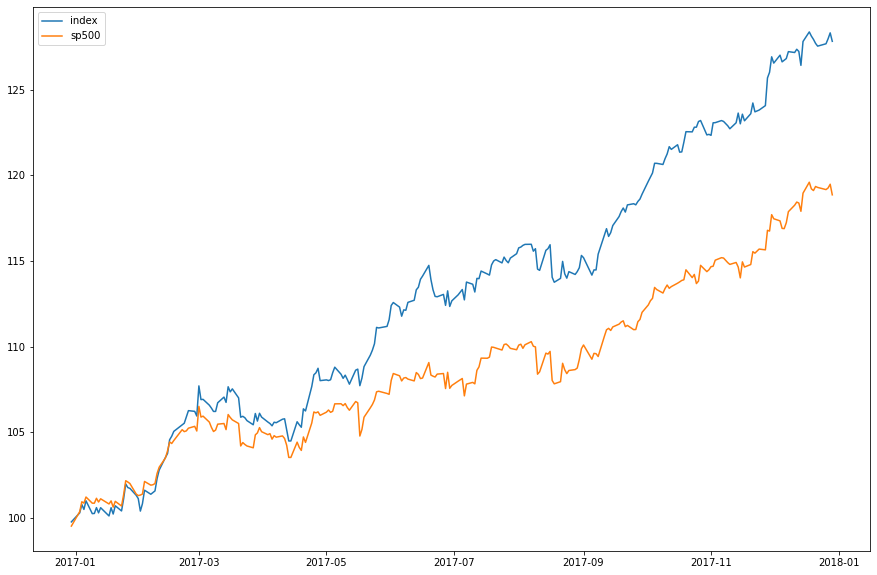

In [83]:
plot_index_sp500(X_test,w_sklearn)